# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-vc3aq8wj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-vc3aq8wj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=00da585aa508d818651cb04a5a24bd39a56a8db46d226389578b9ca4ade46b14
  Stored in directory: /tmp/pip-ephem-wheel-cache-rjhh79r8/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-04-30 17:21:28--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

## Set-up

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [27]:
image = cv2.imread('a_lamp_with_flowers.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

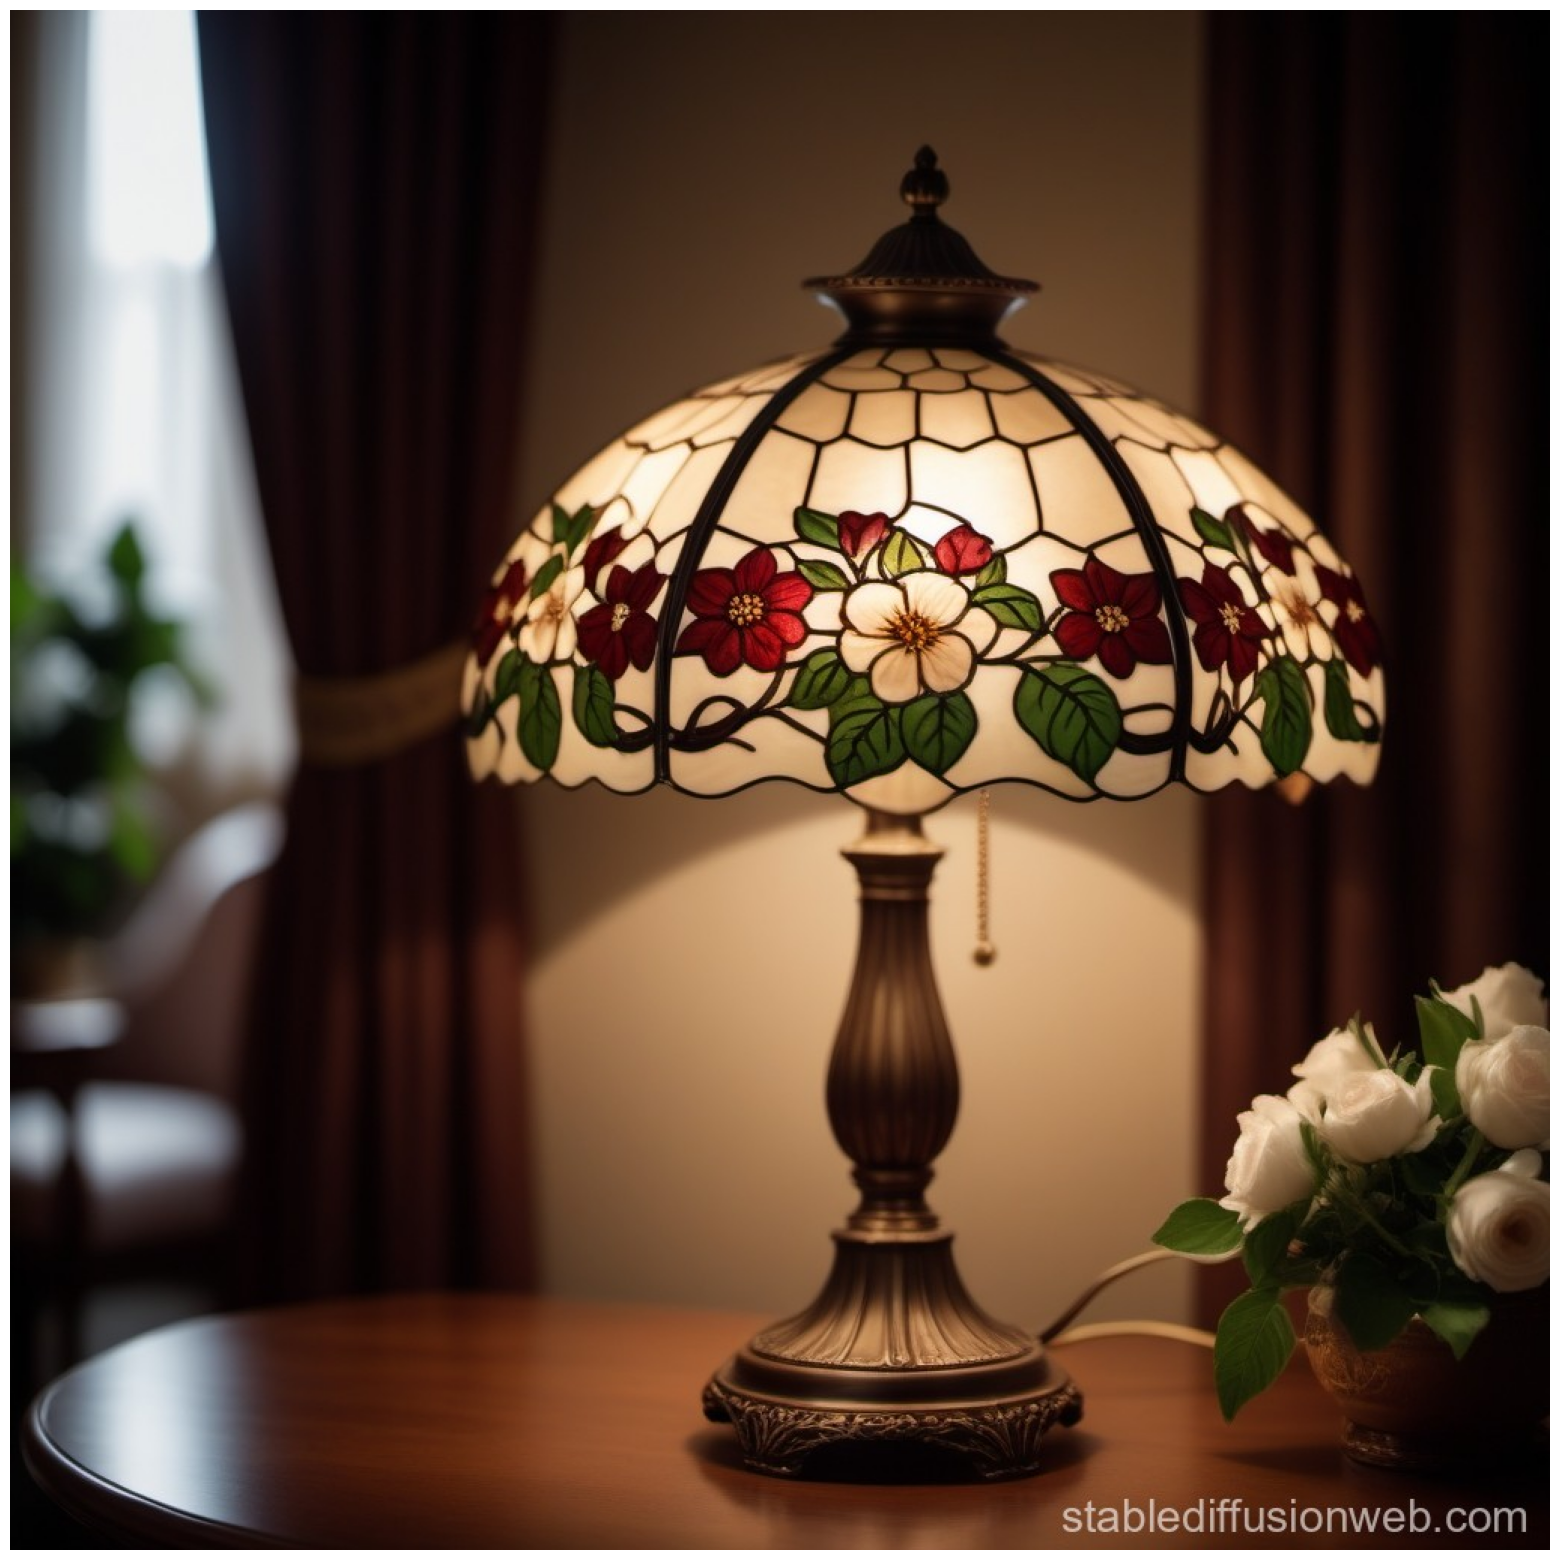

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [9]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [10]:
print(len(masks))
print(masks[0].keys())

94
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [11]:
print(type(image))

<class 'numpy.ndarray'>


In [43]:
# Function that inputs the output and plots image and mask
def show_output(image, result_dict,axes=None,num_seg=5):
     if axes:
        ax = axes
     else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
     sorted_result = sorted(result_dict, key=(lambda x: x['predicted_iou']),      reverse=True)
     # Plot for each segment area
     mask_list = []
     for val in sorted_result:
        mask = val['segmentation']
        mask_list.append(mask)
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        # print(img)
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            # ax.imshow(np.dstack((img, mask*0.5)))
            ax.imshow(np.dstack((img, mask)))
        num_seg-=1
        if num_seg < 0:
          break
     return mask_list

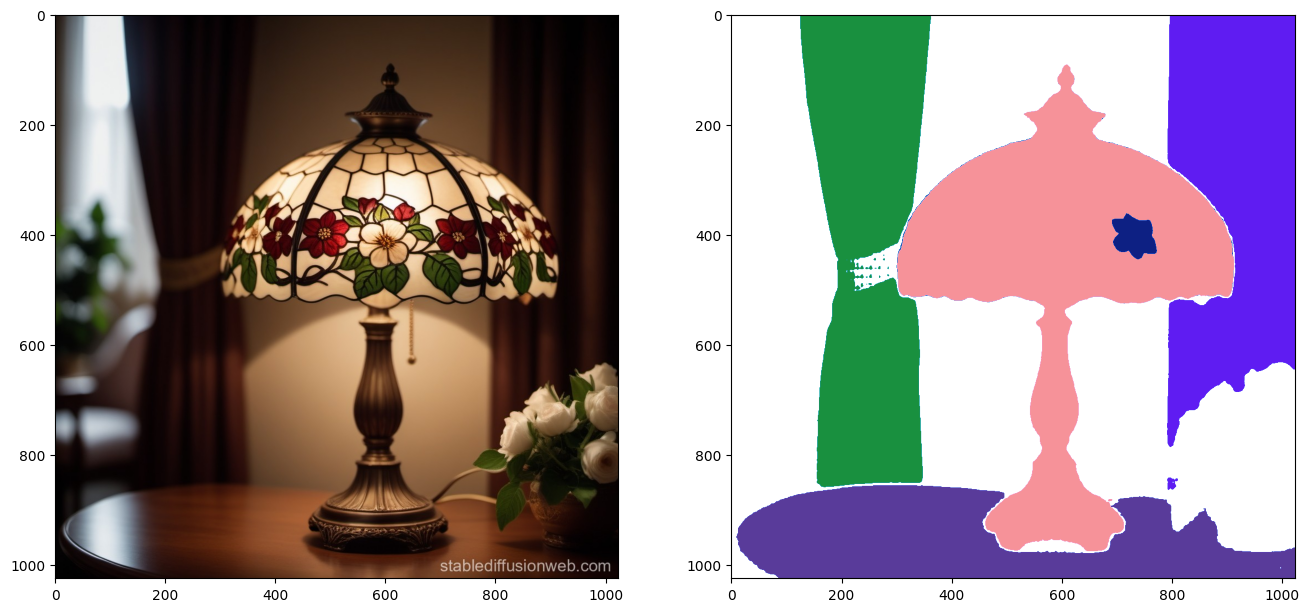

In [44]:
_,axes = plt.subplots(1,2, figsize=(16,16))
axes[0].imshow(image)
list_of_mat = show_output(image, masks, axes[1])



In [14]:
def subset_masks(masks, sett):
  masks_copy = []
  for i in range(len(masks)):
    for j in sett:
      if i ==j:
        masks_copy.append(masks[i])
  masks = masks_copy
  x_dim = masks[0].shape[0]
  y_dim = masks[0].shape[1]
  mask = np.zeros((x_dim, y_dim), dtype=bool)
  for m in masks:
    mask = np.logical_or(mask, m)
  return mask

In [15]:
included = (1,2,3)
included = [1,2,3]
agg_mask = subset_masks(list_of_mat, included)

In [16]:
print(agg_mask)

[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


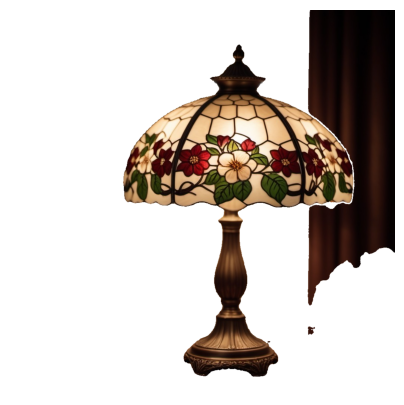

In [17]:
agg_mask = subset_masks(list_of_mat, included)
image_copy = image
mask = agg_mask
for row in range(mask.shape[0]):
  for col in range(mask.shape[1]):
    if mask[row][col] == False:
      image_copy[row][col] = [255, 255, 255]
plt.figure(figsize=(5,5))
plt.imshow(image_copy)
plt.axis('off')
plt.show()


In [18]:
def calc_subsets(prompt, results, subset, index):
  # Add the current subset to the result list
    results.append(subset[:])

    # Generate subsets by recursively including and excluding elements
    for i in range(index, len(prompt)):
        # Include the current element in the subset
        subset.append(prompt[i])

        # Recursively generate subsets with the current element included
        calc_subsets(prompt, results, subset, i + 1)

        # Exclude the current element from the subset (backtracking)
        subset.pop()


def subsets(prompt):
    #split string into list of strings:
    prompt = prompt.split()
    subset = []
    results = []
    index = 0
    calc_subsets(prompt, results, subset, index)

    #exclude empty set
    results = results[1:]

    #join strings
    results = [' '.join(result) for result in results]
    return results


# Get Clip Code Ready

In [19]:
!pip install git+https://github.com/openai/CLIP.git
!pip install open_clip_torch
!pip install sentence_transformers

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-w60373x_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-w60373x_
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [20]:
import open_clip
from PIL import Image

In [21]:
# image processing model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model.to(device)

100%|████████████████████████████████████████| 834M/834M [00:04<00:00, 175MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 896, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=896, out_features=896, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=896, out_features=3584, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3584, out_features=896, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((896,), eps=1e-05, elementwise_affine

In [35]:
from sentence_transformers import util

In [32]:
def imageEncoder(img):
    img1 = Image.fromarray(img).convert('RGB')
    img1 = preprocess(img1).unsqueeze(0).to(device)
    img1 = model.encode_image(img1)
    return img1
def generateScore(image1, image2):
    # test_img = cv2.imread(image1, cv2.IMREAD_UNCHANGED)
    # data_img = cv2.imread(image2, cv2.IMREAD_UNCHANGED)
    # img1 = imageEncoder(test_img)
    # img2 = imageEncoder(data_img)
    img1 = image1
    img2 = image2
    cos_scores = util.pytorch_cos_sim(img1, img2)
    score = round(float(cos_scores[0][0])*100, 2)
    return score

I have a bunch of words and a bunch of objects. Want to aggregate for each object (there will be five) the rank of the best words. This can be done thorugh the similarity score of everywhere that subset is being used being aggregated.

In [33]:
prompt = 'a lamp with flowers'
similarities = {}
clip_embeddings = {}
counter = 0
for i in prompt.split():
  similarities[i] = 0
  # a
  string = str(i) + '.jpg'
  im1 = cv2.imread(string)
  im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
  clip_embeddings[i] = imageEncoder(im1)

print(similarities)

{'a': 0, 'lamp': 0, 'with': 0, 'flowers': 0}


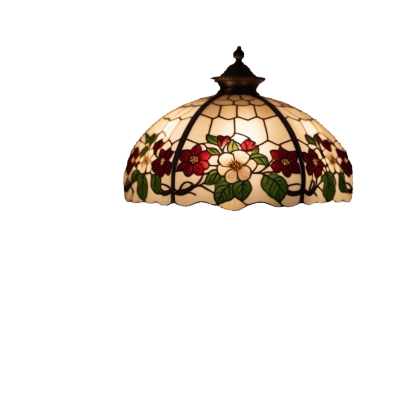

23.42
42.5
23.42
31.16


In [37]:
subset1 = [1]
agg_mask = subset_masks(list_of_mat, subset1)
image_copy = np.copy(image)
mask = agg_mask
for row in range(mask.shape[0]):
  for col in range(mask.shape[1]):
    if mask[row][col] == False:
      image_copy[row][col] = [255, 255, 255]
encoder = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
encoder = imageEncoder(encoder)
plt.figure(figsize=(5,5))
plt.imshow(image_copy)
plt.axis('off')
plt.show()
print(generateScore(clip_embeddings['a'], encoder))
print(generateScore(clip_embeddings['lamp'], encoder))
print(generateScore(clip_embeddings['with'], encoder))
print(generateScore(clip_embeddings['flowers'], encoder))


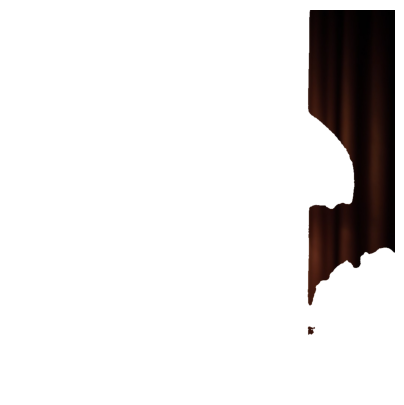

The Embedding with 'a' 20.99
The Embedding with 'lamp' 36.34
The Embedding with 'with' 20.99
The Embedding with 'flowers' 21.2


In [38]:
subset1 = [2]
agg_mask = subset_masks(list_of_mat, subset1)
image_copy = np.copy(image)
mask = agg_mask
for row in range(mask.shape[0]):
  for col in range(mask.shape[1]):
    if mask[row][col] == False:
      image_copy[row][col] = [255, 255, 255]
encoder = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
encoder = imageEncoder(encoder)
plt.figure(figsize=(5,5))
plt.imshow(image_copy)
plt.axis('off')
plt.show()
print("The Embedding with 'a'", generateScore(clip_embeddings['a'], encoder))
print("The Embedding with 'lamp'",generateScore(clip_embeddings['lamp'], encoder))
print("The Embedding with 'with'",generateScore(clip_embeddings['with'], encoder))
print("The Embedding with 'flowers'",generateScore(clip_embeddings['flowers'], encoder))


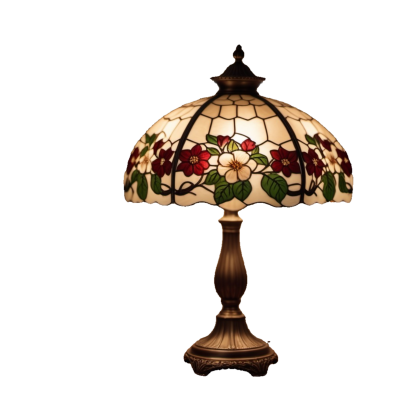

The Embedding with 'a' 26.77
The Embedding with 'lamp' 56.57
The Embedding with 'with' 26.77
The Embedding with 'flowers' 31.29


In [39]:
subset1 = [3]
agg_mask = subset_masks(list_of_mat, subset1)
image_copy = np.copy(image)
mask = agg_mask
for row in range(mask.shape[0]):
  for col in range(mask.shape[1]):
    if mask[row][col] == False:
      image_copy[row][col] = [255, 255, 255]
encoder = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
encoder = imageEncoder(encoder)
plt.figure(figsize=(5,5))
plt.imshow(image_copy)
plt.axis('off')
plt.show()
print("The Embedding with 'a'", generateScore(clip_embeddings['a'], encoder))
print("The Embedding with 'lamp'",generateScore(clip_embeddings['lamp'], encoder))
print("The Embedding with 'with'",generateScore(clip_embeddings['with'], encoder))
print("The Embedding with 'flowers'",generateScore(clip_embeddings['flowers'], encoder))


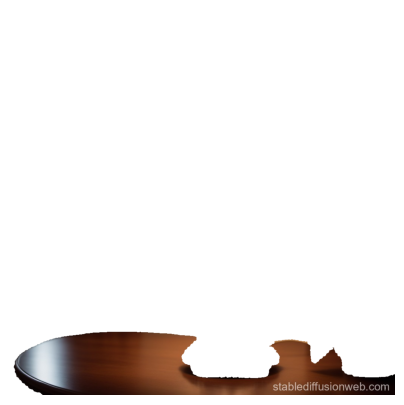

The Embedding with 'a' 24.08
The Embedding with 'lamp' 33.01
The Embedding with 'with' 24.08
The Embedding with 'flowers' 24.64


In [42]:
subset1 = [0]
agg_mask = subset_masks(list_of_mat, subset1)
image_copy = np.copy(image)
mask = agg_mask
for row in range(mask.shape[0]):
  for col in range(mask.shape[1]):
    if mask[row][col] == False:
      image_copy[row][col] = [255, 255, 255]
encoder = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
encoder = imageEncoder(encoder)
plt.figure(figsize=(5,5))
plt.imshow(image_copy)
plt.axis('off')
plt.show()
print("The Embedding with 'a'", generateScore(clip_embeddings['a'], encoder))
print("The Embedding with 'lamp'",generateScore(clip_embeddings['lamp'], encoder))
print("The Embedding with 'with'",generateScore(clip_embeddings['with'], encoder))
print("The Embedding with 'flowers'",generateScore(clip_embeddings['flowers'], encoder))


Show all the masks overlayed on the image.

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()